# **MINE4201 - Taller 1**



## **1. Librerias e imports**

In [ ]:
!pip install numpy
!pip install scikit-surprise
!pip install pandas

In [ ]:
import os
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random
import matplotlib.pyplot as plt

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

## **2. Carga de archivos**

In [ ]:
ratings=pd.read_csv('/content/rating.csv', sep = ',', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ], skiprows=1)

In [ ]:
movies=pd.read_csv('/content/movie.csv', sep = ',', names = [ "movieId","title","genres" ],skiprows=1 )

In [ ]:
tags=pd.read_csv('/content/tag.csv', sep = ',', names = [ "userId","movieId","tag","timestamp" ],skiprows=1)

### **2.1 Verificación que los archivos se han cargado correctamente**

In [ ]:
ratings.head()

,user_id,item_id,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


## **3. Conocimiento del dataset**



### **3.1 Completitud en el dataset**

In [ ]:
ratings_null=ratings.isnull().sum()
movies_null=movies.isnull().sum()
tags_null=tags.isnull().sum()

ratings_null, movies_null, tags_null

(user_id      0
 item_id      0
 rating       0
 timestamp    0
 dtype: int64,
 movieId    0
 title      0
 genres     0
 dtype: int64,
 userId        0
 movieId       0
 tag          16
 timestamp     0
 dtype: int64)

### **Identificación valores únicos**

In [ ]:
#contar valores unicos en tags
tags['tag'].nunique()

38643

In [ ]:
#número de peliculas en el dataset
movies['title'].nunique()

27262

In [ ]:
#número de usuarios en el dataset
ratings['user_id'].nunique()

138493

### **3.2 Distribuciones**

**Distribución de ratings**

Text(0.5, 1.0, 'Distribución de ratings totales por rating')

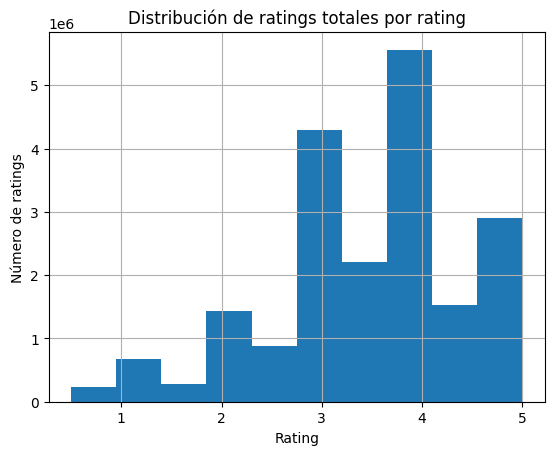

In [ ]:
plot = ratings.rating.hist()
plot.set_ylabel("Número de ratings")
plot.set_xlabel("Rating")
plot.set_title('Distribución de ratings totales por rating')

**Distribución de número deratings por usuarios**

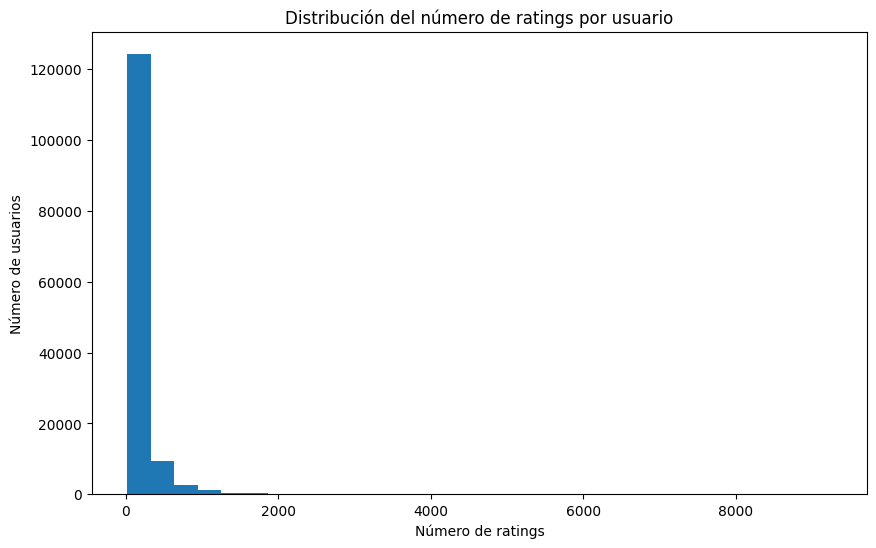

In [ ]:
distribucion_count = ratings.groupby('user_id')['rating'].count()
plt.figure(figsize=(10, 6))
plt.hist(distribucion_count, bins=30)
plt.xlabel('Número de ratings')
plt.ylabel('Número de usuarios')
plt.title('Distribución del número de ratings por usuario')
plt.show()

**Distribución del promedio de calificación por usuario**

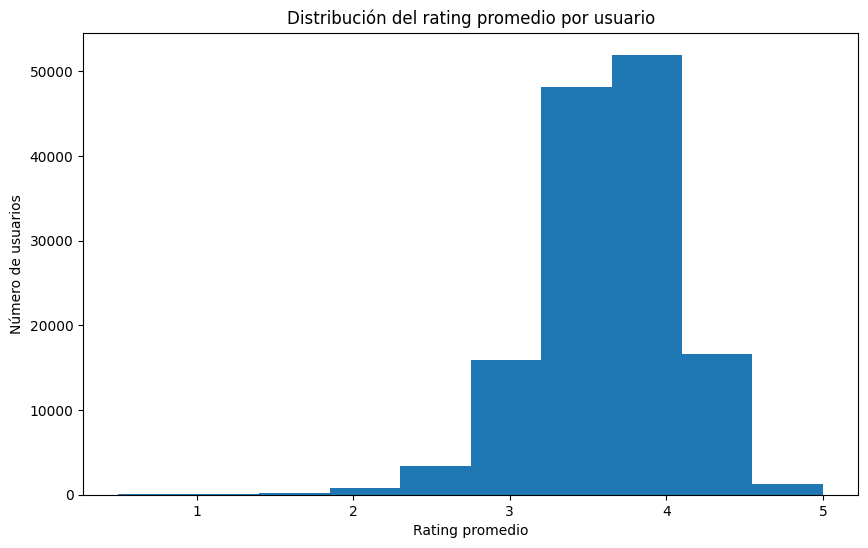

In [ ]:
distribucion_mean = ratings.groupby('user_id')['rating'].mean()
plt.figure(figsize=(10, 6))
plt.hist(distribucion_mean, bins=10)
plt.xlabel('Rating promedio')
plt.ylabel('Número de usuarios')
plt.title('Distribución del rating promedio por usuario')
plt.show()

### **3.3 Muestreo Estratificado**

Para asegurar que la muestra tomada cuente con  una proprocion similar de los ratings con respecto al dataset original, se va a utilizar el muestreo estratificado.

In [ ]:
from sklearn.model_selection import train_test_split
ratings_sample, discarded = train_test_split(ratings, test_size=0.8, stratify=ratings["rating"], random_state=42)

Text(0.5, 1.0, 'Distribución del sample de ratings totales por rating')

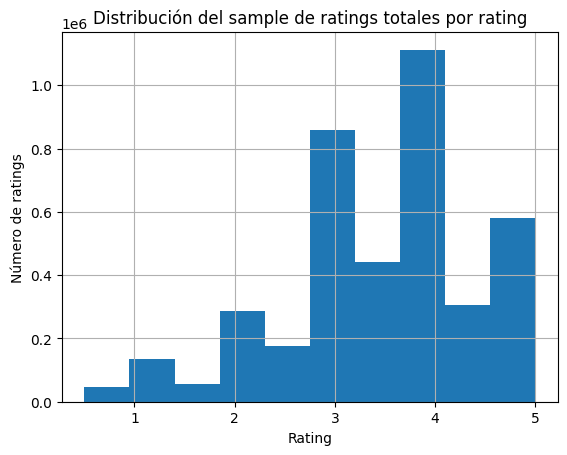

In [ ]:
plot = ratings_sample.rating.hist()
plot.set_ylabel("Número de ratings")
plot.set_xlabel("Rating")
plot.set_title('Distribución del sample de ratings totales por rating')

Se evidencia que los ratings de la muestra tienen una distribución muy similar a la del data set original.

In [ ]:
print("Número de registros")
print("sample: " + str(len(ratings_sample)))
print("real: " + str(len(ratings)))

Número de registros
sample: 4000052
real: 20000263


In [ ]:
movies_sample = movies[movies["movieId"].isin(ratings_sample["item_id"])]

In [ ]:
print("Número de registros")
print("sample: " + str(len(movies_sample)))
print("real: " + str(len(movies)))

Número de registros
sample: 20282
real: 27278


### **3.4 Exploración de métricas por pelicula**

**Número de ratings por items, el promedio de sus calificaciones y la varianza de sus calificaciones**

In [ ]:
ratings_sample

,user_id,item_id,rating,timestamp
7004037,48291,1779,4.5,2014-04-24 21:53:00
12925658,89262,56757,3.5,2009-01-01 04:50:25
7881994,54321,7045,4.0,2005-03-18 16:17:38
13004770,89793,1732,3.5,2006-02-17 11:06:49
10321943,71381,96432,2.5,2014-03-07 16:15:39
...,...,...,...,...
8465668,58434,225,4.0,1996-07-07 03:56:57
9885243,68293,1777,2.5,2008-07-27 20:06:54
14211866,98144,3688,4.0,2000-06-07 22:22:24
5233150,35876,254,3.0,1996-10-15 09:39:32


In [ ]:
ratings_agg = ratings_sample.groupby('item_id')['rating'].agg(['count', 'mean', 'var'])
ratings_agg = ratings_agg.join(movies.set_index('movieId')['title'], on='item_id', how='left')

In [ ]:
ratings_agg

,count,mean,var,title
item_id,,,,
1,10019,3.919054,0.792259,Toy Story (1995)
2,4476,3.196939,0.912547,Jumanji (1995)
3,2486,3.130732,1.043063,Grumpier Old Men (1995)
4,561,2.872549,1.187745,Waiting to Exhale (1995)
5,2494,3.050120,0.930299,Father of the Bride Part II (1995)
...,...,...,...,...
131237,1,3.000000,NaN,What Men Talk About (2010)
131243,1,4.000000,NaN,Werner - Gekotzt wird später (2003)
131248,1,4.000000,NaN,Brother Bear 2 (2006)


**Peliculas con más calificaciones**

In [ ]:
mt=ratings_sample.groupby('item_id')['rating'].agg({'count','mean','var'}).join(movies_sample['title'], how='left')
mt[:10]

,mean,var,count,title
item_id,,,,
1,3.919054,0.792259,10019,Jumanji (1995)
2,3.196939,0.912547,4476,Grumpier Old Men (1995)
3,3.130732,1.043063,2486,Waiting to Exhale (1995)
4,2.872549,1.187745,561,Father of the Bride Part II (1995)
5,3.050120,0.930299,2494,Heat (1995)
6,3.839545,0.753292,4830,Sabrina (1995)
7,3.367528,0.901603,2710,Tom and Huck (1995)
8,3.205479,0.789248,292,Sudden Death (1995)
9,2.989018,0.839142,774,GoldenEye (1995)


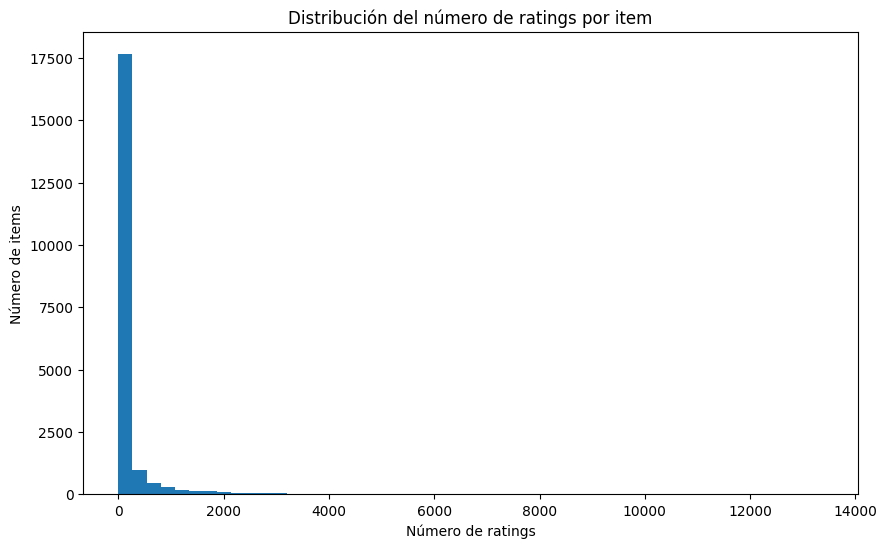

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(mt["count"], bins=50)
plt.xlabel('Número de ratings')
plt.ylabel('Número de items')
plt.title('Distribución del número de ratings por item')
plt.show()

### **3.5 Conclusiones**
- Los datasets que se van a usar para el taller son: movies y ratings, ya que con estos contienen la información fundamental para generar los modelos colaborativos.
- La muestra se hizo con el 20% de los datos, para tener una muetsra significativa con la misma distribución de los dataset original.
- La distribución de número de ratings por item indican que pocas películas son muy vistas y calificadas, mientras que muchas otras reciben pocas calificaciones (tiene una distribución long-tail)
- La mayoría de los usuarios califican con valores cercanos a 4 y 5, lo que sugiere que la mayoría de las calificaciones son positivas. La mayoría de los usuarios dan ratings con un promedio cercano a 4, y muy pocos usuarios califican con promedios bajos.
- La mayoría de los usuarios califican pocas películas, mientras que unos pocos usuarios califican muchas.


## **4. Pre-procesamiento de datos**

### **4.1 One hot encode para géneros**

Es necesario procesar el genero de las peliculas, haciendo one hot encode con el fin que se pueda procesar en los modelos de predicción y se pueda procesar esta información de las peliculas de manera adecuada.

In [ ]:
movies_sample.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
all_genres = set()
for genres in movies_sample['genres']:
  all_genres.update(genres.split('|'))

for genre in all_genres:
  movies_sample[genre] = movies_sample['genres'].apply(lambda x: 1 if genre in x else 0)

movies_sample = movies_sample.drop('genres', axis=1)
movies_sample.head()

<ipython-input-45-f865d9e9e4c3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_sample[genre] = movies_sample['genres'].apply(lambda x: 1 if genre in x else 0)
<ipython-input-45-f865d9e9e4c3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_sample[genre] = movies_sample['genres'].apply(lambda x: 1 if genre in x else 0)
<ipython-input-45-f865d9e9e4c3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,movieId,title,Animation,IMAX,Action,Drama,Film-Noir,Musical,Comedy,Western,...,War,Fantasy,Thriller,Adventure,(no genres listed),Sci-Fi,Crime,Romance,Children,Documentary
0,1,Toy Story (1995),1,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
1,2,Jumanji (1995),0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Waiting to Exhale (1995),0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print("Número de géneros: " + str(len(all_genres)))

Número de géneros: 20
